In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
trades = pd.read_csv('../data/2023-06-11/trades.csv')

trades.index = pd.to_datetime(trades.DATE+' '+trades.TIME_M)
del trades['DATE'], trades['TIME_M']

In [3]:
times = trades.index.to_series().astype(int).values*1e-9

In [167]:
events = trades.EX.factorize()[0]#*3 + (np.sign(trades.PRICE.diff().fillna(0))+1).astype(int).values

# Quasi EM

\begin{equation}
\log L(\mathcal T;\nu,\alpha,\beta,B) = \sum_{t\in \mathcal T}\log\lambda(t) - \int_0^T \lambda(t)dt
\\= \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) + \beta (t_i-t_j)\right) - T\nu - \sum_{t\in\mathcal T} \int_t^T \alpha\exp\left(-\beta(s-t)\right)ds
\\= \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) + \beta (t_i-t_j)\right) - T\nu - \sum_{t\in\mathcal T} \left[-\frac{\alpha}{\beta}\exp\left(-\beta(s-t)\right)\right]_t^T
\\= \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) + \beta (t_i-t_j)\right) - T\nu + \frac{\alpha}{\beta}\sum_{t\in\mathcal T} \left[\exp\left(-\beta(s-t)\right)\right]_t^T
\\\approx \sum_{j}B_{0,j}\log\nu + \sum_{j}\sum_{i>0} B_{i,j} \left(\log(\alpha) + \beta (t_i-t_j)\right) - T\nu - \frac{\alpha}{\beta}N_T \text{ (quasi-EM approximation)}
\\= \log(\nu) \left(\sum_{j}B_{0,j}\right) + \log(\alpha) \left(\sum_{j}\sum_{i>0} B_{i,j}\right) + \beta \left(\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)\right) -\nu (T)- \frac{\alpha}{\beta}\left(N_T\right)
\end{equation}

where
\begin{equation}
B_{i,j} = \frac{1}{\lambda(t_j)} \cdot \begin{cases}\alpha\exp(-\beta(t_j-t_i)), & i>0\\ \nu, & i=0\end{cases}
\end{equation}

implying

\begin{equation}
\nu = \frac{\sum_{j}B_{0,j}}{T} \\
\frac{\alpha}{\beta} = \frac{\sum_{j}\sum_{i>0} B_{i,j}}{N_T} \\
\frac{\alpha}{\beta^2} = -\frac{\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)}{N_T}
\end{equation}

i.e.

\begin{equation}
\nu = \frac{\sum_{j}B_{0,j}}{T} \\
\beta = -\frac{\sum_{j}\sum_{i>0} B_{i,j}}{\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)} \\
\alpha = -\frac{\left(\sum_{j}\sum_{i>0} B_{i,j}\right)^2}{N_T\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)}
\end{equation}


Note that $$\sum_j\sum_i B_{i,j}(t_i-t_j)$$ can be computed in linear time with a backwards and forwards pass, since

\begin{equation}
\sum_j\sum_{i<j} B_{i,j}(t_i-t_j)
\\= \sum_i t_i\sum_{j>i} B_{i,j} - \sum_j t_j\sum_{0<i<j} B_{i,j}
\\= \sum_i t_i\sum_{j>i} \frac{\alpha}{\lambda(t_j)}\exp\left(-\beta(t_j-t_i)\right) - \sum_j t_j\sum_{0<i<j} \frac{\alpha}{\lambda(t_j)}\exp\left(-\beta(t_j-t_i)\right)
\\= \sum_i t_i\sum_{j>i} \frac{\alpha}{\lambda(t_j)}\exp\left(-\beta(t_j-t_i)\right) - \sum_j t_j \frac{\alpha}{\lambda(t_j)}\sum_{0<i<j}\exp\left(-\beta(t_j-t_i)\right)
\\= \text{backwards} - \text{forwards}
\end{equation}

with $B_{i,j}$ computed recursively each time (using the final intensity from the forwards pass as the initial intensity for the backwards pass). There is some risk here of catastrophic cancellation.

## Univariate

In [83]:
import jax
import jax.numpy as jnp
import numpy as np
import scipy as sp
import scipy.optimize
import tqdm
def em(times, T=None, iters=100):
    times = times.copy() - times[0]
    if T is None:
        T = times[-1]
    N_T = len(times)
        
    nu = np.float64(1.0)
    alpha = np.float64(1.0)
    beta = np.float64(2.0)
    
    for _ in tqdm.trange(iters):
        #E step
        sum_j_B_0_j = 0
        sum_j_sum_i_B_i_j = 0
        forwards_pass = 0
        backwards_pass = 0
        
        intensities = np.zeros_like(times)
        endo_intensity = 0
        prev_t = 0
        for i,t in enumerate(times):
            endo_intensity *= np.exp(-beta*(t-prev_t))
            intensities[i] = nu+endo_intensity
            B_0_j = nu/intensities[i]
            sum_j_B_0_j += B_0_j
            sum_i_B_i_j = endo_intensity/intensities[i]
            sum_j_sum_i_B_i_j += sum_i_B_i_j
            forwards_pass += t*sum_i_B_i_j
            endo_intensity += alpha
            prev_t = t

        sum_j_B_i_j = 0
        next_t = T
        for i,t in reversed(list(enumerate(times))):
            sum_j_B_i_j *= np.exp(-beta*(next_t-t))
            backwards_pass += t*sum_j_B_i_j
            sum_j_B_i_j += alpha/intensities[i]
            next_t = t
            
            
        constants = np.array([sum_j_B_0_j, sum_j_sum_i_B_i_j, backwards_pass, forwards_pass, T, N_T])
        #constants /= np.std(constants)
        sum_j_B_0_j, sum_j_sum_i_B_i_j, backwards_pass, forwards_pass, T, N_T = constants
        
        #M step
#         def partial_ll(log_nu,log_alpha,log_beta):
#             return log_nu*(sum_j_B_0_j) + log_alpha*sum_j_sum_i_B_i_j + jnp.exp(log_beta)*(backwards_pass-forwards_pass) - jnp.exp(log_nu)*T - jnp.exp(log_alpha-log_beta)*N_T
        
#         print(sum_j_B_0_j, sum_j_sum_i_B_i_j, backwards_pass, forwards_pass, T, N_T)
        
#         starting_partial_ll = partial_ll(log_nu,log_alpha,log_beta)
#         def loss(params):
#             return -partial_ll(*params)/starting_partial_ll
        
#         print(intensities)
#         print(loss([log_nu,log_alpha,log_beta]))
#         print(jax.grad(loss)([log_nu,log_alpha,log_beta]))
#         print(log_nu,log_alpha,log_beta)
        
        
#         constraint = sp.optimize.LinearConstraint([[0,-1,1]], lb=[0], ub=[np.inf], keep_feasible=False)
#         sol=sp.optimize.minimize(loss, jac=jax.grad(loss), x0=[log_nu,log_alpha,log_beta], constraints=constraint, method='trust-constr',options=dict(maxiter=2))
#         print(sol)
#         log_nu,log_alpha,log_beta = sol.x

        assert backwards_pass<forwards_pass, (backwards_pass,forwards_pass)
        nu = sum_j_B_0_j/T
        alpha = -sum_j_sum_i_B_i_j**2/(N_T*(backwards_pass-forwards_pass))
        beta = -sum_j_sum_i_B_i_j/(backwards_pass-forwards_pass)
        print(nu,alpha,beta)
        
    return nu,alpha,beta

In [85]:
nu,alpha,beta = em(times)

  1%|██                                                                                                                                                                                                       | 1/100 [00:01<02:53,  1.75s/it]

0.6514700338268925 3.0441386001158555 3.4829597509139463


  2%|████                                                                                                                                                                                                     | 2/100 [00:05<04:29,  2.75s/it]

0.37941400962270616 5.649282654772688 6.096633323369974


  3%|██████                                                                                                                                                                                                   | 3/100 [00:09<05:16,  3.26s/it]

0.34965898082895625 9.91746630391001 10.636746581153275


  4%|████████                                                                                                                                                                                                 | 4/100 [00:11<04:49,  3.01s/it]

0.4578452149886453 17.145979261970243 18.811654484028303


  5%|██████████                                                                                                                                                                                               | 5/100 [00:12<03:45,  2.38s/it]

0.6539888332073709 30.99745959278329 35.48560831709483


  6%|████████████                                                                                                                                                                                             | 6/100 [00:14<03:12,  2.05s/it]

0.8846757821262076 62.10303202028686 74.9214690894854


  7%|██████████████                                                                                                                                                                                           | 7/100 [00:15<02:55,  1.88s/it]

1.1079515731525382 138.23296899050064 175.9297996758537


  8%|████████████████                                                                                                                                                                                         | 8/100 [00:17<02:42,  1.77s/it]

1.2952721884429803 311.97285923591545 416.2406539285096


  9%|██████████████████                                                                                                                                                                                       | 9/100 [00:18<02:32,  1.67s/it]

1.4344479328788955 622.3440290819066 861.2741127388559


 10%|████████████████████                                                                                                                                                                                    | 10/100 [00:20<02:33,  1.71s/it]

1.537294045173328 1043.5033592366763 1485.0009365781943


 11%|██████████████████████                                                                                                                                                                                  | 11/100 [00:22<02:24,  1.62s/it]

1.6118527900126078 1503.8457382561248 2184.9452901811824


 12%|████████████████████████                                                                                                                                                                                | 12/100 [00:23<02:14,  1.53s/it]

1.665196390541888 1929.7216828788744 2846.3660185316826


 13%|██████████████████████████                                                                                                                                                                              | 13/100 [00:24<02:11,  1.51s/it]

1.7037389464362005 2289.469021636931 3414.539946594609


 14%|████████████████████████████                                                                                                                                                                            | 14/100 [00:26<02:09,  1.50s/it]

1.731035938813934 2577.3749459312776 3874.4306527819317


 15%|██████████████████████████████                                                                                                                                                                          | 15/100 [00:28<02:10,  1.54s/it]

1.750368007398624 2799.0119715783985 4231.387127440961


 16%|████████████████████████████████                                                                                                                                                                        | 16/100 [00:29<02:14,  1.60s/it]

1.7641562318642043 2965.940540529296 4501.888116925212


 17%|██████████████████████████████████                                                                                                                                                                      | 17/100 [00:33<03:05,  2.24s/it]

1.7740466373584454 3090.1621767639635 4704.096780238626


 18%|████████████████████████████████████                                                                                                                                                                    | 18/100 [00:35<02:48,  2.06s/it]

1.7811739147035806 3182.0151330540325 4854.108112650902


 19%|██████████████████████████████████████                                                                                                                                                                  | 19/100 [00:36<02:36,  1.93s/it]

1.786330185216009 3249.6454451490813 4964.829484168831


 20%|████████████████████████████████████████                                                                                                                                                                | 20/100 [00:38<02:42,  2.03s/it]

1.7900695877622008 3299.3554884798377 5046.352427630929


 21%|██████████████████████████████████████████                                                                                                                                                              | 21/100 [00:40<02:28,  1.88s/it]

1.7927885224200322 3335.8466633227417 5106.272276363961


 22%|████████████████████████████████████████████                                                                                                                                                            | 22/100 [00:42<02:24,  1.85s/it]

1.7947689947381888 3362.5869998368116 5150.223961929643


 23%|██████████████████████████████████████████████                                                                                                                                                          | 23/100 [00:43<02:17,  1.79s/it]

1.796212263764344 3382.1777066154928 5182.445125997617


 24%|████████████████████████████████████████████████                                                                                                                                                        | 24/100 [00:45<02:14,  1.77s/it]

1.7972653127992635 3396.5206556184444 5206.047122321802


 25%|██████████████████████████████████████████████████                                                                                                                                                      | 25/100 [00:48<02:28,  1.98s/it]

1.7980340159225714 3407.020788309489 5223.331506807876


 26%|████████████████████████████████████████████████████                                                                                                                                                    | 26/100 [00:51<02:48,  2.27s/it]

1.7985955386609425 3414.7114991336075 5235.993932544099


 27%|██████████████████████████████████████████████████████                                                                                                                                                  | 27/100 [00:54<03:01,  2.48s/it]

1.7990061420211478 3420.352449611831 5245.282236826642


 28%|████████████████████████████████████████████████████████                                                                                                                                                | 28/100 [00:55<02:40,  2.23s/it]

1.7993069140323505 3424.477484872158 5252.076687198012


 29%|█████████████████████████████████████████████████████████▉                                                                                                                                              | 29/100 [00:57<02:26,  2.07s/it]

1.7995267315362449 3427.5147989315633 5257.0777347311005


 30%|████████████████████████████████████████████████████████████                                                                                                                                            | 30/100 [00:59<02:22,  2.04s/it]

1.7996883803457202 3429.715726003101 5260.705735250913


 31%|██████████████████████████████████████████████████████████████                                                                                                                                          | 31/100 [01:01<02:17,  2.00s/it]

1.7998056379898755 3431.3421316401223 5263.383492970632


 32%|████████████████████████████████████████████████████████████████                                                                                                                                        | 32/100 [01:03<02:18,  2.04s/it]

1.7998921051952337 3432.5230702234044 5265.330009844201


 33%|██████████████████████████████████████████████████████████████████                                                                                                                                      | 33/100 [01:05<02:10,  1.94s/it]

1.799954970698601 3433.3827422211234 5266.746929168057


 34%|████████████████████████████████████████████████████████████████████                                                                                                                                    | 34/100 [01:09<02:59,  2.73s/it]

1.800000721348353 3433.999524187785 5267.76455864468


 35%|██████████████████████████████████████████████████████████████████████                                                                                                                                  | 35/100 [01:16<04:22,  4.04s/it]

1.8000335882815242 3434.4511586417307 5268.508738076484


 36%|████████████████████████████████████████████████████████████████████████                                                                                                                                | 36/100 [01:19<03:48,  3.57s/it]

1.8000576076358672 3434.800573459185 5269.082293239087


 37%|██████████████████████████████████████████████████████████████████████████                                                                                                                              | 37/100 [01:20<03:06,  2.96s/it]

1.8000760887941856 3435.0525109585383 5269.4976644938515


 38%|████████████████████████████████████████████████████████████████████████████                                                                                                                            | 38/100 [01:22<02:45,  2.67s/it]

1.8000894967008565 3435.2320322491496 5269.7940189121255


 39%|██████████████████████████████████████████████████████████████████████████████                                                                                                                          | 39/100 [01:25<02:41,  2.65s/it]

1.8000990674449824 3435.3540239360746 5269.996123092219


 40%|████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 40/100 [01:27<02:28,  2.47s/it]

1.8001056038428913 3435.462197879473 5270.172286957559


 41%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 41/100 [01:29<02:15,  2.29s/it]

1.8001112603497427 3435.534635331232 5270.292254040727


 42%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 42/100 [01:31<02:11,  2.27s/it]

1.8001151395832677 3435.5759181788467 5270.3616496836585


 43%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 43/100 [01:33<02:02,  2.16s/it]

1.800117397244622 3435.618550838429 5270.430580646406


 44%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 44/100 [01:35<01:55,  2.07s/it]

1.8001196037128646 3435.6725867695936 5270.516924920289


 45%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 45/100 [01:37<01:50,  2.01s/it]

1.8001223535076423 3435.678189926445 5270.529820205609


 46%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 46/100 [01:38<01:44,  1.94s/it]

1.8001228188732028 3435.6997480767545 5270.563619335421


 47%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 47/100 [01:40<01:40,  1.89s/it]

1.8001238862582882 3435.7022870127694 5270.56918324526


 48%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 48/100 [01:42<01:35,  1.84s/it]

1.8001240843573159 3435.7055305557637 5270.574468792254


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 49/100 [01:44<01:33,  1.84s/it]

1.800124254107988 3435.7181728235837 5270.5941282097965


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 50/100 [01:46<01:30,  1.81s/it]

1.8001248726737153 3435.695205362045 5270.559861999007


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 51/100 [01:47<01:28,  1.80s/it]

1.800123815182245 3435.7120396805285 5270.584033271404


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 52/100 [01:49<01:24,  1.77s/it]

1.8001245470966938 3435.699427498367 5270.565829912371


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 53/100 [01:51<01:24,  1.79s/it]

1.800123994435663 3435.708471657455 5270.578840007151


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 54/100 [01:53<01:21,  1.77s/it]

1.8001243887594092 3435.706600256771 5270.576585760232


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 55/100 [01:54<01:18,  1.75s/it]

1.8001243271823775 3435.702188789988 5270.56972202417


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 56/100 [01:56<01:14,  1.69s/it]

1.800124111168641 3435.7124148532243 5270.585071633649


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 57/100 [01:59<01:37,  2.27s/it]

1.8001245862538433 3435.714115176831 5270.588422907813


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 58/100 [02:05<02:20,  3.35s/it]

1.8001247017808173 3435.7279355970177 5270.6098048960575


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 59/100 [02:13<03:04,  4.50s/it]

1.8001253729829592 3435.722208144162 5270.60206818774


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 60/100 [02:19<03:23,  5.08s/it]

1.8001251462326786 3435.7361036731195 5270.623030189681


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 61/100 [02:23<03:09,  4.85s/it]

1.8001257965664288 3435.735578550695 5270.623241536597


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 62/100 [02:26<02:35,  4.10s/it]

1.8001258178714825 3435.7172979170236 5270.595231268616


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 63/100 [02:28<02:07,  3.45s/it]

1.800124942503462 3435.719171413301 5270.596736532059


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 64/100 [02:30<01:54,  3.18s/it]

1.8001249697896045 3435.7246314117233 5270.6051551595165


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 65/100 [02:33<01:44,  2.98s/it]

1.80012523364753 3435.732366974556 5270.617434561199


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 66/100 [02:35<01:33,  2.75s/it]

1.8001256235731387 3435.717071285588 5270.5945797828535


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 67/100 [02:37<01:24,  2.57s/it]

1.8001249177413512 3435.729452500823 5270.612469609198


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 68/100 [02:39<01:14,  2.34s/it]

1.8001254611858517 3435.7239854912623 5270.604932664759


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 69/100 [02:42<01:19,  2.56s/it]

1.8001252377950283 3435.728533148009 5270.611559728741


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 70/100 [02:45<01:19,  2.66s/it]

1.8001254399675797 3435.710862449677 5270.584767959894


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 71/100 [02:46<01:08,  2.36s/it]

1.8001246067868173 3435.7161194279724 5270.591529654483


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 72/100 [02:48<00:59,  2.13s/it]

1.8001247993895126 3435.7361880183007 5270.622617227281


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 73/100 [02:50<00:54,  2.01s/it]

1.8001257758155729 3435.743805416805 5270.63582959196


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 74/100 [02:52<00:51,  2.00s/it]

1.800126211015809 3435.7428292434356 5270.635012600684


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 75/100 [02:53<00:46,  1.86s/it]

1.8001261953042589 3435.733075390956 5270.620025039183


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 76/100 [02:55<00:43,  1.83s/it]

1.8001257263060335 3435.7331418764625 5270.619393668081


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 77/100 [02:57<00:41,  1.82s/it]

1.8001256959653187 3435.753220363971 5270.6501478209


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 78/100 [02:58<00:38,  1.73s/it]

1.8001266569242884 3435.74307671964 5270.636089505514


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 79/100 [03:00<00:36,  1.74s/it]

1.800126239054558 3435.7349433724935 5270.622959046455


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 80/100 [03:02<00:33,  1.67s/it]

1.8001258190377538 3435.7325080203454 5270.618566297924


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 81/100 [03:03<00:31,  1.66s/it]

1.8001256721900196 3435.7365438074257 5270.624527812077


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 82/100 [03:05<00:30,  1.67s/it]

1.800125855280974 3435.7307438516914 5270.6159166310235


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 83/100 [03:07<00:29,  1.73s/it]

1.8001255901570992 3435.7222102184837 5270.602410960231


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 84/100 [03:09<00:28,  1.79s/it]

1.8001251618586822 3435.7351821937777 5270.621641019702


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 85/100 [03:11<00:26,  1.80s/it]

1.80012575348186 3435.7298838354636 5270.614438133417


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 86/100 [03:12<00:25,  1.82s/it]

1.8001255416257 3435.7265793239812 5270.6090375402655


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 87/100 [03:14<00:22,  1.75s/it]

1.8001253679677238 3435.7375198515524 5270.625549414464


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 88/100 [03:16<00:20,  1.73s/it]

1.800125880350496 3435.7306037830263 5270.615740957534


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 89/100 [03:17<00:19,  1.75s/it]

1.8001255852304867 3435.716348798106 5270.5934114887805


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 90/100 [03:19<00:18,  1.81s/it]

1.800124880343604 3435.7072883679643 5270.5784100387655


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 91/100 [03:24<00:22,  2.49s/it]

1.8001243953346362 3435.7139706189196 5270.587902612226


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 92/100 [03:27<00:23,  2.92s/it]

1.8001246811973508 3435.708317074906 5270.579676737112


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 93/100 [03:31<00:21,  3.09s/it]

1.800124430442611 3435.701711401657 5270.569151147001


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 94/100 [03:34<00:18,  3.11s/it]

1.8001240956513267 3435.7011484592244 5270.567764058172


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 95/100 [03:36<00:13,  2.78s/it]

1.8001240447128448 3435.6974270029536 5270.561975474308


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 96/100 [03:38<00:09,  2.45s/it]

1.8001238625582032 3435.7100749176225 5270.5810932899685


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 97/100 [03:40<00:06,  2.30s/it]

1.8001244562369922 3435.709042562841 5270.580437914861


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 98/100 [03:42<00:04,  2.18s/it]

1.8001244491601995 3435.7191985723775 5270.5960067665865


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 99/100 [03:44<00:02,  2.15s/it]

1.8001249358219233 3435.7288818689813 5270.61162249851


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:46<00:00,  2.26s/it]

1.8001254351062614 3435.7359595820553 5270.6232608516675


In [86]:
#https://math.stackexchange.com/a/4498377
expected_number_events = nu*(times[-1]-times[0])/(1-alpha/beta) + (alpha*nu/(alpha-beta)**2)*(np.exp(-(times[-1]-times[0])*(beta-alpha))-1)
expected_number_events, len(times)

(297794.9981630469, 297795)

# Multivariate

\begin{equation}
\log L(\mathcal T;\nu,\alpha,\beta,B) \approx \sum_{e}\left(\log(\nu_e) \left(\sum_{j}B_{0,j} \delta_{e,e_j}\right) + \sum_{e'} \left(\log(\alpha_{e',e}) \left(\sum_{j}\sum_{i>0} B_{i,j}\delta_{e',e_i}\delta_{e,e_j}\right) + \beta_{e',e} \left(\sum_{j}\sum_{i>0} B_{i,j}(t_i-t_j)\delta_{e',e_i}\delta_{e,e_j}\right) -\nu_e (T)- \frac{\alpha_{e',e}}{\beta_{e',e}}\sum_i \delta_{e',e_i}\right)\right)
\end{equation}

where
\begin{equation}
B_{i,j} = \frac{1}{\lambda_{e_j}(t_j)} \cdot \begin{cases}\alpha_{e_i,e_j}\exp(-\beta_{e_i,e_j}(t_j-t_i)), & i>0\\ \nu_{e_j}, & i=0\end{cases}
\end{equation}

In [159]:
import jax
import jax.numpy as jnp
import numpy as np
import scipy as sp
import scipy.optimize
import tqdm
def em(times, events, T=None, iters=100):
    assert len(times) == len(events), (len(times),len(events))
    times = times.copy() - times[0]
    if T is None:
        T = times[-1]
    N_T = len(times)
    num_event_types = len(set(events))
        
    nu = np.ones(num_event_types)
    alpha = np.ones((num_event_types,num_event_types))
    beta = 2*np.ones((num_event_types,num_event_types))
    
    for _ in tqdm.trange(iters):
        #E step
        sum_j_B_0_j = np.zeros(num_event_types)
        sum_j_sum_i_B_i_j = np.zeros((num_event_types,num_event_types))
        forwards_pass = np.zeros((num_event_types,num_event_types))
        backwards_pass = np.zeros((num_event_types,num_event_types))
        
        intensities = np.zeros_like(times)
        endo_intensity = np.zeros((num_event_types,num_event_types))
        prev_t = 0
        for j,(t,e) in enumerate(zip(times,events)):
            endo_intensity *= np.exp(-beta*(t-prev_t))
            intensities[j] = nu[e]+endo_intensity[:,e].sum()
            B_0_j = nu[e]/intensities[j]
            sum_j_B_0_j[e] += B_0_j
            sum_i_B_i_j = endo_intensity[:,e]/intensities[j]
            sum_j_sum_i_B_i_j[:,e] += sum_i_B_i_j
            forwards_pass[:,e] += t*sum_i_B_i_j
            endo_intensity[e,:] += alpha[e,:]
            prev_t = t

        sum_j_B_i_j = np.zeros((num_event_types,num_event_types))
        next_t = T
        for i,(t,e) in reversed(list(enumerate(zip(times,events)))):
            sum_j_B_i_j *= np.exp(-beta*(next_t-t))
            backwards_pass[e,:] += t*sum_j_B_i_j[e,:]
            sum_j_B_i_j[:,e] += alpha[:,e]/intensities[i]
            next_t = t
            
        #M step
#         def partial_ll(log_nu,log_alpha,log_beta):
#             return log_nu*(sum_j_B_0_j) + log_alpha*sum_j_sum_i_B_i_j + jnp.exp(log_beta)*(backwards_pass-forwards_pass) - jnp.exp(log_nu)*T - jnp.exp(log_alpha-log_beta)*N_T
        
#         print(sum_j_B_0_j, sum_j_sum_i_B_i_j, backwards_pass, forwards_pass, T, N_T)
        
#         starting_partial_ll = partial_ll(log_nu,log_alpha,log_beta)
#         def loss(params):
#             return -partial_ll(*params)/starting_partial_ll
        
#         print(intensities)
#         print(loss([log_nu,log_alpha,log_beta]))
#         print(jax.grad(loss)([log_nu,log_alpha,log_beta]))
#         print(log_nu,log_alpha,log_beta)
        
        
#         constraint = sp.optimize.LinearConstraint([[0,-1,1]], lb=[0], ub=[np.inf], keep_feasible=False)
#         sol=sp.optimize.minimize(loss, jac=jax.grad(loss), x0=[log_nu,log_alpha,log_beta], constraints=constraint, method='trust-constr',options=dict(maxiter=2))
#         print(sol)
#         log_nu,log_alpha,log_beta = sol.x
        beta_coef = backwards_pass-forwards_pass
        #assert np.all(beta_coef<0), (beta_coef,beta_coef.max())
        
        nu = sum_j_B_0_j/T
        alpha = np.nan_to_num(np.where(beta_coef<0,-sum_j_sum_i_B_i_j**2/(N_T*beta_coef),0))
        beta = np.nan_to_num(np.where(beta_coef<0,-sum_j_sum_i_B_i_j/beta_coef,0))
        beta = beta.clip(alpha,np.inf)

        print(nu,alpha,beta)
        plt.imshow(alpha/beta)
        plt.show()
        
    return nu,alpha,beta

In [155]:
nu,alpha,beta = em(times,np.zeros_like(times,dtype=int))

(array([1.80012544]), array([[3435.73595958]]), array([[5270.62326085]]))

  0%|                                                                                                                                                                                                                 | 0/100 [00:00<?, ?it/s]

[2.56404998e-02 1.06044364e-01 3.91378645e-02 2.50850067e-02
 2.46146325e-02 8.49927550e-03 3.51767946e-01 2.44056585e-02
 1.15249272e-02 8.71213522e-03 6.29459328e-03 9.06700482e-03
 4.82859401e-03 9.50339254e-05 5.10634687e-03 6.46151645e-04] [[1.03359839e-01 4.96118394e-02 8.16659528e-02 6.08606836e-03
  4.57045113e-02 1.47333197e-02 3.63079173e-02 1.08685568e-02
  3.20328945e-02 2.18282603e-03 6.29446616e-04 2.55577909e-03
  2.83809020e-03 8.78618126e-05 2.99803649e-02 2.63079685e-03]
 [2.77453886e-01 6.50877446e-01 2.58667417e-01 2.24528704e-02
  2.38246413e-01 4.62588046e-02 1.05590709e-01 3.36281955e-02
  1.63521786e-01 6.64327386e-03 4.01654702e-03 1.07080725e-02
  2.86960738e-02 2.67063333e-04 9.01434735e-02 7.96167905e-03]
 [2.19863832e-02 3.66593745e-02 1.06929408e-01 6.32280638e-03
  1.99203176e-02 1.02614792e-02 4.25596564e-02 1.27605733e-02
  1.10277933e-02 2.07641085e-03 8.02366022e-04 2.45894444e-03
  2.01834753e-03 8.20072211e-05 1.02063190e-02 2.66883214e-03]
 [7.7057

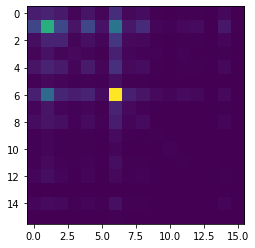

  1%|██                                                                                                                                                                                                       | 1/100 [00:14<23:11, 14.06s/it]

[1.90262701e-02 9.67089269e-02 3.68011539e-02 3.98220320e-02
 1.77715322e-02 9.43853534e-03 5.66877218e-01 3.63175690e-02
 6.92647645e-03 1.40705836e-02 8.77144671e-03 1.35392235e-02
 4.30058392e-03 9.66119082e-05 2.42022074e-03 4.05597089e-04] [[1.08452245e+00 2.65905766e-02 5.05083783e-01 5.51085630e-03
  1.08140613e-01 5.22929444e-02 2.05759373e-02 1.91154409e-02
  9.76965273e-02 2.95942873e-03 1.87706514e-04 2.64627679e-03
  2.26175698e-03 1.31256740e-04 2.13438027e-01 1.42038569e-02]
 [4.61949674e+00 8.99523901e+00 4.31646535e+00 7.10395018e-02
  3.39393738e+00 4.77379509e-01 1.48330825e-01 1.59366766e-01
  3.01285047e+00 2.04105276e-02 7.63257397e-03 4.39864820e-02
  3.68452922e-01 9.21727798e-04 1.72909105e+00 1.38369898e-01]
 [1.18578232e-02 1.14557490e-02 9.51974206e-01 5.37582662e-03
  1.02093979e-02 1.84011215e-02 2.48370708e-02 2.52523993e-02
  4.58322734e-03 2.09274701e-03 3.08537960e-04 2.06838026e-03
  7.66122634e-04 8.18802801e-05 1.01277579e-02 1.50747199e-02]
 [2.5367

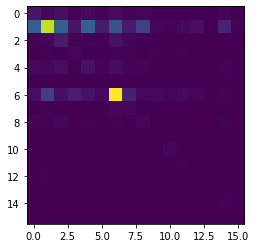

  2%|████                                                                                                                                                                                                     | 2/100 [00:22<17:27, 10.68s/it]

[1.71481656e-02 8.99730711e-02 3.51833102e-02 4.19056431e-02
 1.43150195e-02 9.89644692e-03 6.51216281e-01 3.69355315e-02
 5.54698127e-03 1.23766515e-02 8.19152216e-03 1.12162422e-02
 3.22269656e-03 6.66578972e-05 1.76883701e-03 3.25596409e-04] [[1.03742175e+01 9.10510144e-03 2.23357335e+00 5.78477262e-03
  1.56817177e-01 1.74780415e-01 1.69877659e-02 5.25285474e-02
  1.51735081e-01 7.73424403e-03 3.60824152e-05 3.06658446e-03
  1.25793263e-03 1.75324976e-04 8.16037391e-01 4.00846519e-02]
 [3.36502809e+01 7.59898021e+01 3.85862252e+01 2.50504951e-01
  2.47551020e+01 3.55564677e+00 2.65476484e-01 9.16236175e-01
  2.49454457e+01 7.46126721e-02 1.20628865e-02 2.08864664e-01
  3.07520053e+00 2.76936818e-03 1.18925577e+01 1.15979492e+00]
 [3.92351748e-03 2.36793102e-03 8.72648877e+00 4.73613139e-03
  2.50425190e-03 2.27014548e-02 1.83253773e-02 7.30389700e-02
  8.74815792e-04 2.69417619e-03 7.48188732e-05 1.53141958e-03
  1.57904439e-04 4.65349137e-05 2.98256984e-03 3.50202468e-02]
 [1.8926

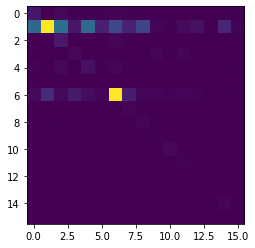

  3%|██████                                                                                                                                                                                                   | 3/100 [00:30<15:35,  9.64s/it]

[2.05307685e-02 1.06038658e-01 4.09110566e-02 3.56916983e-02
 1.61931210e-02 1.08546189e-02 6.87749955e-01 3.24839544e-02
 6.40048253e-03 9.70944953e-03 8.73351359e-03 8.74361689e-03
 3.25033888e-03 5.55459809e-05 2.17161254e-03 3.49464052e-04] [[6.39043114e+01 9.78178171e-03 4.36467425e+00 6.51341757e-03
  1.73669911e-01 5.01479459e-01 2.49007859e-02 1.85210943e-01
  2.11421156e-01 3.86603566e-02 7.36970156e-06 3.51517539e-03
  2.04236971e-03 1.46764849e-04 2.13112446e+00 8.52878086e-02]
 [9.16435471e+01 3.69807808e+02 1.00242867e+02 8.05649333e-01
  8.63654777e+01 1.25129836e+01 7.07827941e-01 3.85093755e+00
  7.29292702e+01 1.91032643e-01 2.96010103e-02 6.29967150e-01
  1.13363816e+01 8.51851953e-03 2.94679181e+01 3.15814935e+00]
 [3.94655507e-03 1.38283377e-03 5.67035594e+01 4.33278735e-03
  1.73369231e-03 3.38466466e-02 2.02392196e-02 2.62901318e-01
  4.76322640e-04 4.07936898e-03 2.16169229e-05 1.31065039e-03
  6.19838331e-05 1.22925714e-05 3.12179304e-03 5.18697908e-02]
 [5.1956

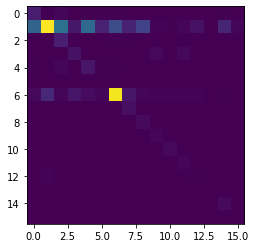

  4%|████████                                                                                                                                                                                                 | 4/100 [00:39<15:05,  9.43s/it]

[2.23831469e-02 1.19634237e-01 4.56006733e-02 3.46353491e-02
 1.82009338e-02 1.10146816e-02 7.05589064e-01 3.19333906e-02
 7.10367041e-03 1.03073170e-02 8.83600275e-03 9.66450502e-03
 3.35495478e-03 5.48388799e-05 2.35493277e-03 3.27020227e-04] [[2.69195132e+02 2.93769942e-02 4.65405841e+00 1.14968071e-02
  2.22619249e-01 1.17055932e+00 6.04863852e-02 5.28521737e-01
  3.66031277e-01 2.83072915e-01 1.51381431e-06 1.65775142e-02
  1.00253242e-02 7.82491152e-05 3.90487930e+00 1.29381393e-01]
 [1.35591640e+02 1.13625194e+03 1.12485983e+02 1.82922221e+00
  1.49990344e+02 2.15705583e+01 2.41059314e+00 7.37346764e+00
  1.05053873e+02 4.61514615e-01 9.74275570e-02 1.32882628e+00
  2.44738633e+01 1.88399398e-02 3.32879760e+01 3.84631405e+00]
 [6.89067380e-03 1.83078230e-03 3.34620339e+02 5.80736754e-03
  2.48279011e-03 6.26516729e-02 3.12864526e-02 7.36271782e-01
  5.25948351e-04 2.48746092e-02 6.48417415e-06 3.21959917e-03
  4.13591351e-05 2.83239232e-06 5.77157170e-03 8.78626237e-02]
 [2.7872

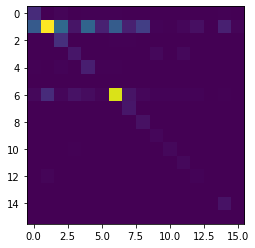

  5%|██████████                                                                                                                                                                                               | 5/100 [00:48<14:27,  9.13s/it]

[2.28077174e-02 1.27554413e-01 4.82835287e-02 3.67970173e-02
 1.92562547e-02 1.08629419e-02 7.23221449e-01 3.34217390e-02
 7.45216707e-03 1.10217429e-02 8.44251727e-03 1.05370200e-02
 3.16301933e-03 5.71983955e-05 2.35306407e-03 3.11428674e-04] [[7.89170341e+02 1.78476718e-01 3.95932307e+00 5.15740993e-02
  3.50649148e-01 1.91954924e+00 1.63031119e-01 9.27660550e-01
  6.44096442e-01 7.38525292e-01 3.30288643e-07 1.19936384e-01
  5.32413284e-02 4.90378761e-05 5.37766344e+00 1.46708651e-01]
 [1.41455736e+02 2.46318023e+03 8.51832515e+01 3.10861452e+00
  1.64427040e+02 2.50828093e+01 7.34025377e+00 9.17761237e+00
  9.47091025e+01 9.15907495e-01 3.65179700e-01 2.10725538e+00
  3.90173776e+01 5.24806639e-02 2.65813547e+01 3.83951490e+00]
 [1.71043070e-02 5.25079607e-03 1.82934721e+03 1.69508169e-02
  5.40476583e-03 1.03832305e-01 5.77209864e-02 1.54420990e+00
  1.05178492e-03 2.49099119e-01 1.72813545e-06 1.52322944e-02
  4.19460432e-05 2.73873558e-06 1.06295850e-02 1.62568763e-01]
 [1.7063

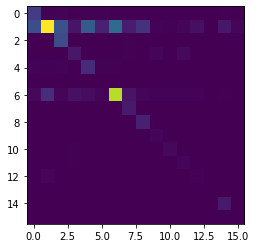

  6%|████████████                                                                                                                                                                                             | 6/100 [00:58<14:33,  9.29s/it]

[2.28483199e-02 1.28355359e-01 4.97031102e-02 3.83387035e-02
 1.98690075e-02 1.08923545e-02 7.48727102e-01 3.50692855e-02
 7.59615493e-03 1.16473764e-02 8.51557443e-03 1.09545358e-02
 2.84484444e-03 5.55748810e-05 2.42562177e-03 3.13982174e-04] [[1.58882391e+03 1.12209101e+00 3.54115676e+00 3.22642943e-01
  5.51169606e-01 2.48643646e+00 3.35487831e-01 1.12467348e+00
  1.12084750e+00 9.38372109e-01 8.48271115e-08 4.23818318e-01
  1.68625634e-01 5.60430046e-05 7.21225938e+00 1.42660421e-01]
 [1.26466395e+02 4.27578386e+03 5.81200231e+01 4.15835350e+00
  1.44347749e+02 2.59889550e+01 1.34973580e+01 9.85391289e+00
  7.16592872e+01 1.34957453e+00 9.60411256e-01 2.70175695e+00
  5.23619460e+01 1.30034882e-01 2.40185203e+01 3.67259340e+00]
 [4.81365035e-02 2.40840525e-02 5.82603451e+03 8.21131181e-02
  1.43727094e-02 1.51453932e-01 9.80532496e-02 2.52665693e+00
  2.88261711e-03 1.05306744e+00 5.59312427e-07 5.78366984e-02
  7.18743872e-05 4.10315183e-06 1.63439845e-02 4.12475325e-01]
 [5.5208

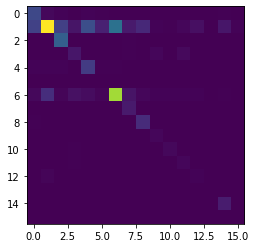

  7%|██████████████                                                                                                                                                                                           | 7/100 [01:06<14:12,  9.16s/it]

[2.28665883e-02 1.25016320e-01 5.03422624e-02 3.90676879e-02
 2.02302343e-02 1.10264330e-02 7.75361012e-01 3.65735535e-02
 7.69666263e-03 1.22025854e-02 8.65261526e-03 1.11805657e-02
 2.63437916e-03 5.22773685e-05 2.56954378e-03 3.19915040e-04] [[2.31052890e+03 3.40703886e+00 3.84161549e+00 1.03602630e+00
  8.07010030e-01 2.86118652e+00 5.70391109e-01 1.17282957e+00
  2.08547111e+00 9.32810297e-01 2.63641795e-08 8.41883761e-01
  3.16003615e-01 6.39754367e-05 9.46926542e+00 1.22300413e-01]
 [1.13167282e+02 6.75020094e+03 5.13707273e+01 4.76235045e+00
  1.22344274e+02 2.61975321e+01 1.72736884e+01 9.99211991e+00
  6.74987540e+01 1.62635138e+00 1.98932795e+00 3.00458822e+00
  6.61646656e+01 1.63711259e-01 2.39738463e+01 3.41834920e+00]
 [1.17725629e-01 9.32538086e-02 1.13795548e+04 4.23387919e-01
  3.54914299e-02 2.07998590e-01 1.53350001e-01 3.47351351e+00
  8.90727342e-03 2.19297405e+00 2.11566817e-07 1.31885658e-01
  2.31594246e-04 6.22191319e-06 2.16734547e-02 1.71956375e+00]
 [9.2125

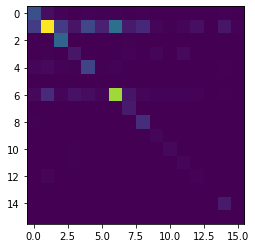

  8%|████████████████                                                                                                                                                                                         | 8/100 [01:15<13:46,  8.99s/it]

[2.29576797e-02 1.24365417e-01 5.10180448e-02 3.97083394e-02
 2.03305912e-02 1.12390234e-02 7.96784646e-01 3.78741199e-02
 7.81738468e-03 1.26423559e-02 8.82085678e-03 1.13410613e-02
 2.55537492e-03 4.97338910e-05 2.75698383e-03 3.18147555e-04] [[2.76065960e+03 5.58446743e+00 4.24920814e+00 1.80929439e+00
  1.14220003e+00 3.08621703e+00 8.25855810e-01 1.17208721e+00
  4.34125526e+00 8.88384799e-01 1.06738164e-08 1.25313635e+00
  4.58772655e-01 7.26855485e-05 1.15531502e+01 9.25279535e-02]
 [1.06134364e+02 9.44250799e+03 5.10682242e+01 5.03149004e+00
  1.11503452e+02 2.62265212e+01 1.91042451e+01 9.95023422e+00
  6.95995894e+01 1.78190966e+00 2.86887815e+00 3.11344347e+00
  7.97932099e+01 1.74658959e-01 2.38776952e+01 2.99152930e+00]
 [2.18579461e-01 2.68171820e-01 1.84866089e+04 1.15786886e+00
  7.12980085e-02 2.82347516e-01 2.32770396e-01 4.27800399e+00
  2.48029946e-02 3.27355948e+00 9.26442234e-08 2.12761725e-01
  9.89971388e-04 9.03515347e-06 2.89193963e-02 6.28968990e+00]
 [1.1971

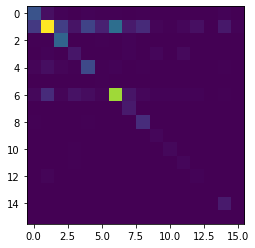

  9%|██████████████████                                                                                                                                                                                       | 9/100 [01:25<14:12,  9.37s/it]

[2.31106055e-02 1.25346499e-01 5.11368445e-02 4.02955163e-02
 2.04541046e-02 1.14780316e-02 8.13924175e-01 3.87600087e-02
 8.13559693e-03 1.29436070e-02 8.94195696e-03 1.14353174e-02
 2.51943312e-03 4.76900690e-05 2.94456717e-03 3.14572987e-04] [[2.99763033e+03 7.25581648e+00 4.55305342e+00 2.39350471e+00
  1.52995081e+00 3.21048023e+00 1.03156546e+00 1.16611497e+00
  8.97286549e+00 8.55073473e-01 6.27369393e-09 1.58630493e+00
  5.99782945e-01 8.14848134e-05 1.29623301e+01 6.86386944e-02]
 [1.02509020e+02 1.17249343e+04 5.22805721e+01 5.15609294e+00
  1.07584199e+02 2.61962782e+01 2.00119630e+01 9.90131602e+00
  7.00500613e+01 1.87727560e+00 3.47468297e+00 3.13550691e+00
  9.26340960e+01 1.78967253e-01 2.34708915e+01 2.47380819e+00]
 [3.19374049e-01 5.80199085e-01 2.53547977e+04 1.92811255e+00
  1.15373240e-01 3.91934695e-01 3.45369566e-01 4.91515886e+00
  5.30682077e-02 4.09075434e+00 4.87287638e-08 2.90888001e-01
  5.31334152e-03 1.18381152e-05 3.47110609e-02 1.47366180e+01]
 [1.4202

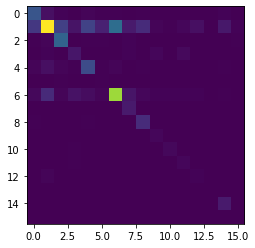

 10%|████████████████████                                                                                                                                                                                    | 10/100 [01:36<14:45,  9.83s/it]

[2.33037448e-02 1.26125112e-01 5.11643794e-02 4.07277699e-02
 2.07521816e-02 1.17185880e-02 8.29215641e-01 3.94329889e-02
 8.36864474e-03 1.30428071e-02 9.05721736e-03 1.14504559e-02
 2.45873749e-03 4.64409633e-05 3.11961452e-03 3.13600161e-04] [[3.11394912e+03 8.57040380e+00 4.78645659e+00 2.80456237e+00
  1.97691246e+00 3.26958418e+00 1.15487168e+00 1.16157816e+00
  1.55876694e+01 8.37182094e-01 5.73292786e-09 1.82956817e+00
  7.37899968e-01 9.02278055e-05 1.38307877e+01 5.64564786e-02]
 [1.00120696e+02 1.33662023e+04 5.43660307e+01 5.23510212e+00
  1.06325748e+02 2.61213072e+01 2.05126416e+01 9.88102488e+00
  6.94434666e+01 1.94892168e+00 3.93367550e+00 3.12972490e+00
  1.04706282e+02 1.81063358e-01 2.31865656e+01 2.10293989e+00]
 [3.97016967e-01 9.83674704e-01 3.08724741e+04 2.53846705e+00
  1.60485794e-01 5.69256790e-01 4.94548616e-01 5.39364686e+00
  8.67685560e-02 4.62138101e+00 3.28241113e-08 3.76298579e-01
  2.91090006e-02 1.42759651e-05 3.73880617e-02 2.21629025e+01]
 [1.6074

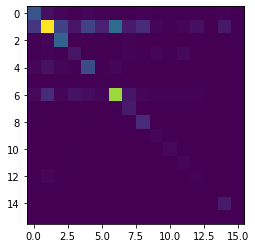

 11%|██████████████████████                                                                                                                                                                                  | 11/100 [01:47<15:00, 10.12s/it]

[2.35713690e-02 1.27305359e-01 5.11917117e-02 4.10202502e-02
 2.11331046e-02 1.19582385e-02 8.44439381e-01 4.00565843e-02
 8.58237586e-03 1.31054816e-02 9.15354906e-03 1.14928604e-02
 2.39532588e-03 4.58699322e-05 3.29010736e-03 3.13924637e-04] [[3.16773374e+03 9.62458390e+00 4.95553205e+00 3.09364770e+00
  2.53194357e+00 3.28403054e+00 1.20324562e+00 1.15661205e+00
  2.35019575e+01 8.29070354e-01 9.08084157e-09 1.99777594e+00
  8.68394704e-01 9.84793761e-05 1.43796912e+01 5.12398904e-02]
 [9.79629548e+01 1.44569888e+04 5.66170526e+01 5.29748500e+00
  1.05858916e+02 2.59779610e+01 2.08354359e+01 9.86421825e+00
  6.90693387e+01 1.99998605e+00 4.30537602e+00 3.11838042e+00
  1.15741260e+02 1.82362507e-01 2.30108276e+01 1.92083093e+00]
 [4.49624304e-01 1.41382137e+00 3.58932602e+04 2.98066101e+00
  2.02764265e-01 8.80310701e-01 6.72667054e-01 5.72970934e+00
  1.18378541e-01 4.93341541e+00 3.24456205e-08 4.72703390e-01
  9.49435961e-02 1.62793431e-05 3.85052036e-02 2.58853268e+01]
 [1.7570

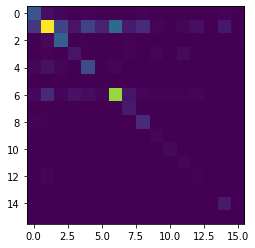

 12%|████████████████████████                                                                                                                                                                                | 12/100 [01:56<14:28,  9.87s/it]

[2.39011575e-02 1.28822660e-01 5.12166830e-02 4.13537963e-02
 2.15274336e-02 1.22070318e-02 8.60574619e-01 4.06718788e-02
 8.85148252e-03 1.31849100e-02 9.23372910e-03 1.15619119e-02
 2.35457823e-03 4.56245821e-05 3.46727877e-03 3.14279260e-04] [[3.18826797e+03 1.06045050e+01 5.08605561e+00 3.29806007e+00
  3.25666446e+00 3.26265708e+00 1.19663514e+00 1.15151749e+00
  3.14852046e+01 8.27486273e-01 2.65216432e-08 2.10894407e+00
  9.96969442e-01 1.06046247e-04 1.47176266e+01 4.89917037e-02]
 [9.55320887e+01 1.51605106e+04 5.87774608e+01 5.35090497e+00
  1.05529442e+02 2.57339717e+01 2.10791940e+01 9.84955581e+00
  6.85629723e+01 2.03538809e+00 4.63245067e+00 3.11206687e+00
  1.24927291e+02 1.83299901e-01 2.28809912e+01 1.84404553e+00]
 [4.83110512e-01 1.84072861e+00 4.11015370e+04 3.29562597e+00
  2.40679519e-01 1.49803299e+00 8.61030103e-01 5.95670110e+00
  1.42719752e-01 5.09552287e+00 5.67147449e-08 5.94685709e-01
  1.81601550e-01 1.78231569e-05 3.90331369e-02 2.72638900e+01]
 [1.8809

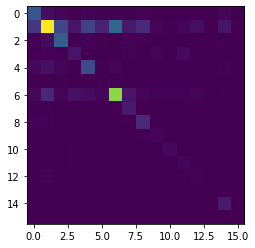

 13%|██████████████████████████                                                                                                                                                                              | 13/100 [02:06<14:08,  9.75s/it]

[2.42485183e-02 1.30443632e-01 5.12312909e-02 4.16874275e-02
 2.19047418e-02 1.24794036e-02 8.78043982e-01 4.12924187e-02
 9.17478036e-03 1.32700638e-02 9.30236737e-03 1.16474216e-02
 2.32945563e-03 4.55420490e-05 3.64287820e-03 3.14674566e-04] [[3.18904279e+03 1.15686456e+01 5.20459539e+00 3.44936268e+00
  4.22201420e+00 3.20302584e+00 1.15163610e+00 1.14688620e+00
  3.84207265e+01 8.29511251e-01 1.20614941e-07 2.17895706e+00
  1.13490942e+00 1.13150495e-04 1.49305540e+01 4.78510848e-02]
 [9.27027876e+01 1.56074801e+04 6.08221316e+01 5.40312549e+00
  1.05142724e+02 2.53784021e+01 2.12825998e+01 9.84177847e+00
  6.80803089e+01 2.06077931e+00 4.93330006e+00 3.11313837e+00
  1.32229266e+02 1.83994702e-01 2.27961608e+01 1.81159985e+00]
 [5.06024230e-01 2.25317065e+00 4.67570275e+04 3.53829094e+00
  2.73593895e-01 2.99134042e+00 1.03632193e+00 6.10756160e+00
  1.59584767e-01 5.17251591e+00 1.65753232e-07 7.52711556e-01
  2.55284242e-01 1.89499994e-05 3.93069566e-02 2.77025166e+01]
 [1.9781

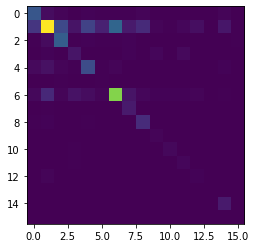

 14%|████████████████████████████                                                                                                                                                                            | 14/100 [02:15<13:41,  9.56s/it]

[2.45991309e-02 1.32079036e-01 5.12829883e-02 4.20392024e-02
 2.22539017e-02 1.27804791e-02 8.97142343e-01 4.19260660e-02
 9.51489892e-03 1.33565371e-02 9.36295953e-03 1.17497584e-02
 2.31390261e-03 4.55460332e-05 3.81238950e-03 3.15102501e-04] [[3.17832507e+03 1.25040567e+01 5.32239871e+00 3.57381639e+00
  5.52419406e+00 3.09212491e+00 1.08061418e+00 1.14285427e+00
  4.38240043e+01 8.32388486e-01 6.63765680e-07 2.22104732e+00
  1.28735100e+00 1.20121359e-04 1.50679274e+01 4.71263169e-02]
 [8.97075094e+01 1.58910057e+04 6.27236982e+01 5.45547791e+00
  1.04672837e+02 2.48767673e+01 2.14551721e+01 9.84281936e+00
  6.76817955e+01 2.07937991e+00 5.21160302e+00 3.12109255e+00
  1.37852767e+02 1.84516864e-01 2.27469516e+01 1.79681847e+00]
 [5.23295095e-01 2.64673393e+00 5.30162657e+04 3.74774579e+00
  3.01240370e-01 7.14210624e+00 1.17905982e+00 6.20712406e+00
  1.71007044e-01 5.20668048e+00 6.90524203e-07 9.48715553e-01
  3.05511830e-01 1.97325642e-05 3.94225687e-02 2.78246136e+01]
 [2.0501

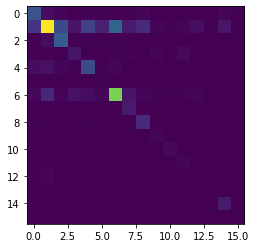

 15%|██████████████████████████████                                                                                                                                                                          | 15/100 [02:24<13:26,  9.49s/it]

In [ ]:
nu,alpha,beta = em(times,events)

In [ ]:
nu,alpha,beta